In this notebook, we will engineer the relatie price feature for *training data* only.

In [1]:
import os
GPU_id = 2
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU_id)

In [2]:
import warnings
warnings.filterwarnings("ignore")

import cudf as gd
import pandas as pd
import numpy as np
from numba import cuda
import os
import time
import nvstrings
from librmm_cffi import librmm
import matplotlib.pyplot as plt
%matplotlib inline

### Global

In [3]:
GPU_RUN_TIME = {}
CPU_RUN_TIME = {}
STEPS = []

### Functions

In [4]:
def on_gpu(words,func,arg=None,dtype=np.int32):
    res = librmm.device_array(words.size(), dtype=dtype)
    if arg is None:
        cmd = 'words.%s(devptr=res.device_ctypes_pointer.value)'%(func)
    else:
        cmd = 'words.%s(arg,devptr=res.device_ctypes_pointer.value)'%(func)
    eval(cmd)
    return res

def count_items(data,cols):
    dg = data.groupby(cols+['item_id'],
            as_index=False).agg({'step':['count']})
    if len(cols) == 0:
        tag = 'global'
    else:
        tag = '_'.join(cols)
    dg.columns = cols + ['item_id', 'count_item_%s'%tag]

    if len(cols):
        df = data.groupby(cols,
            as_index=False).agg({'step':['count']})
        df.columns = cols + ['count_item_%s_all'%tag]
    
        dg = dg.merge(df,on=cols,how='left')
        dg['count_item_%s_norm'%tag] = dg['count_item_%s'%tag] / dg['count_item_%s_all'%tag]
    
        dg = dg.drop('count_item_%s_all'%tag,axis=1)
        del df
    return dg

In [5]:
def get_prev_next_price(price,prev_price,next_price):
    N = len(price)
    for i in range(cuda.threadIdx.x, len(price), cuda.blockDim.x):
        if i>0:
            prev_price[i] = price[i-1]
        else:
            prev_price[i] = 10000 # marker for none
        if i<N-1:
            next_price[i] = price[i+1]
        else:
            next_price[i] = 10000

In [6]:
def pd_next(ds):
    # ds is a pandas data series
    ds.iloc[:-1] = ds.iloc[1:].values
    ds.iloc[-1] = 10000
    return ds

def pd_prev(ds):
    # ds is a pandas data series
    ds.iloc[1:] = ds.iloc[:-1].values
    ds.iloc[0] = 10000
    return ds

### Read pair data

In [7]:
if os.path.exists('cache')==False:
    os.mkdir('cache')

In [8]:
path = '/datasets/trivago/data/'

In [9]:
step = 'prepare'
STEPS.append(step)

In [10]:
%%time
start = time.time()
cols = ['user_id','item_id','timestamp','target','price','clickout_missing']
data_pair_pd = pd.read_pickle('cache/data_pair_gd.pkl')[cols]
data_pair_pd = data_pair_pd[data_pair_pd['clickout_missing']==0] # train only
data_pair_pd['all_row_id'] = np.arange(data_pair_pd.shape[0])
for col in data_pair_pd.columns:
    if data_pair_pd[col].dtype=='int64':
        data_pair_pd[col] = data_pair_pd[col].astype('int32')
data_pair_pd = data_pair_pd.sort_values(by=['user_id','timestamp']) 

click_pd = data_pair_pd[data_pair_pd['target']>0]
click_pd = click_pd.sort_values(by=['user_id','timestamp']) 
CPU_RUN_TIME[step] = time.time() - start

CPU times: user 2min 35s, sys: 55 s, total: 3min 30s
Wall time: 1min


In [11]:
%%time
start = time.time()

data_pair_gd = gd.from_pandas(data_pair_pd)
data_pair_gd['user_id'] = data_pair_gd['user_id'].data.hash()
data_pair_gd = data_pair_gd.sort_values(by=['user_id','timestamp']) 
click_gd = data_pair_gd[data_pair_gd['target']>0]
click_gd = click_gd.sort_values(by=['user_id','timestamp']) 
GPU_RUN_TIME[step] = time.time() - start

CPU times: user 31.8 s, sys: 10.2 s, total: 42 s
Wall time: 12.2 s


In [12]:
print(click_pd.shape,click_gd.shape)

(1856058, 7) (1856058, 7)


### get pervious and next price

In [13]:
step = 'pervious and next price'
STEPS.append(step)

In [14]:
%%time
start = time.time()

click_gd = click_gd.groupby('user_id',method="cudf",as_index=False).apply_grouped(get_prev_next_price,
                                  incols=['price'],
                                  outcols={'prev_price': np.float32,
                                           'next_price':np.float32},
                                  tpb=32)
GPU_RUN_TIME[step] = time.time() - start

CPU times: user 8.06 s, sys: 460 ms, total: 8.52 s
Wall time: 1.18 s


In [15]:
%%time
start = time.time()

next_price = click_pd.groupby('user_id')['price'].apply(pd_next)
next_price = next_price.reset_index()
next_price.columns = ['all_row_id','next_price']
click_pd = click_pd.merge(next_price,on='all_row_id',how='left')

prev_price = click_pd.groupby('user_id')['price'].apply(pd_prev)
prev_price = prev_price.reset_index()
prev_price.columns = ['all_row_id','prev_price']
click_pd = click_pd.merge(prev_price,on='all_row_id',how='left')

CPU_RUN_TIME[step] = time.time() - start

CPU times: user 18min 42s, sys: 13.4 s, total: 18min 55s
Wall time: 18min 8s


In [16]:
print(click_pd.shape,click_gd.shape)

(1856058, 9) (1856058, 9)


### compute difference

In [17]:
step = 'compute difference'
STEPS.append(step)

### cudf compute difference

In [18]:
%%time
start = time.time()

for col in click_gd.columns:
    if col not in ['user_id','timestamp','next_price','prev_price']:
        click_gd.drop_column(col)

data_pair_gd = data_pair_gd.merge(click_gd,on=['user_id','timestamp'],how='left')


data_pair_gd['prev_price_diff'] = data_pair_gd['prev_price'] - data_pair_gd['price']
data_pair_gd['next_price_diff'] = data_pair_gd['next_price'] - data_pair_gd['price']
GPU_RUN_TIME[step] = time.time() - start

CPU times: user 5.36 s, sys: 424 ms, total: 5.79 s
Wall time: 568 ms


### pandas compute difference

In [19]:
%%time
start = time.time()

for col in click_pd.columns:
    if col not in ['user_id','timestamp','next_price','prev_price']:
        click_pd = click_pd.drop(col,axis=1)

data_pair_pd = data_pair_pd.merge(click_pd,on=['user_id','timestamp'],how='left')


data_pair_pd['prev_price_diff'] = data_pair_pd['prev_price'] - data_pair_pd['price']
data_pair_pd['next_price_diff'] = data_pair_pd['next_price'] - data_pair_pd['price']
CPU_RUN_TIME[step] = time.time() - start

CPU times: user 30.7 s, sys: 6.85 s, total: 37.6 s
Wall time: 12 s


### Visualize the timing

In [20]:
GPU_RUN_TIME['Overall'] = sum([GPU_RUN_TIME[i] for i in STEPS])
CPU_RUN_TIME['Overall'] = sum([CPU_RUN_TIME[i] for i in STEPS])
STEPS.append('Overall')

timing = pd.DataFrame()
timing['step'] = STEPS
timing['GPU'] = [GPU_RUN_TIME[i] for i in STEPS]
timing['CPU'] = [CPU_RUN_TIME[i] for i in STEPS]
timing

,step,GPU,CPU
0,prepare,12.181949,60.828371
1,pervious and next price,1.183835,1088.216188
2,compute difference,0.568073,12.002198
3,Overall,13.933858,1161.046757


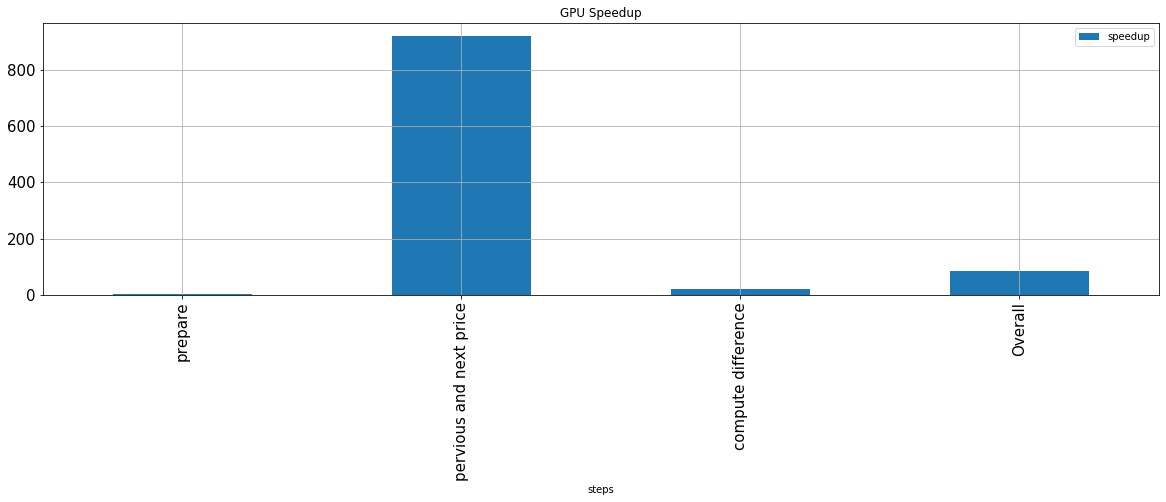

In [21]:
speedup = [CPU_RUN_TIME[i]/GPU_RUN_TIME[i] for i in STEPS]
df = pd.DataFrame({'steps':STEPS, 'speedup':speedup})
ax = df.plot.bar(x='steps', y='speedup', figsize=(20,5), fontsize=15, title='GPU Speedup',grid=True)

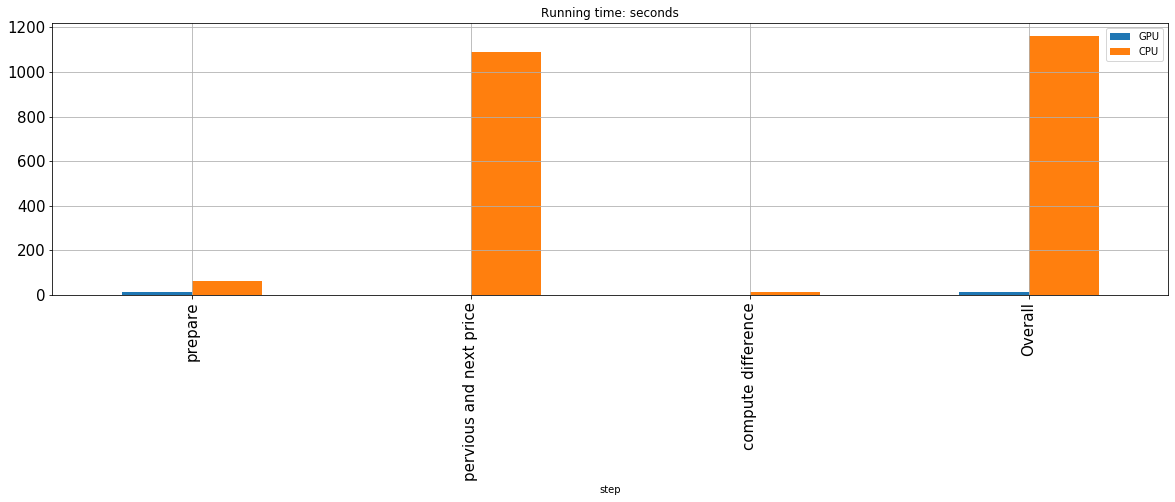

In [22]:
timing.set_index('step').plot.bar(figsize=(20,5),grid=True,fontsize=15, title='Running time: seconds')